# Конструирование и отбор признаков, подбор гиперпараметров модели
<font color=darkblue>Задача: Опредлить объявление о продажи машин будет популярно или нет, по среднему количеству просмотров в день. Эта информация(одно из применений) поможет позволить размещать на популярных страницах рекламные банеры. <br/>
Это задача бинарной классификации, т.к. классов 2 (популярно/нет). 

## 1. Подготовка данных 
<font color=darkblue>Загрузим данные по объявлениям о продажах автомобилей 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.float_format', lambda x: "%.2f" % x)
df = pd.read_csv(u'../data/auto.ru_data.csv')

In [2]:
print(df.shape)
df.head()

(20237, 23)


,Год выпуска,КПП,Привод,Пробег,Тип кузова,Состояние,Срок владения,Цвет,Руль,Владельцы,...,Модель,Город,Объем двигателя,Мощность двигателя,Двигатель,Цена,Дата,Количество дней,Просмотров всего,Просмотров в день
0,2012.00,механическая,передний,141000.00,внедорожник 5 дв.,Не требует ремонта,NaN,белый,Левый,2 владельца,...,ix35 I,Воронеж,2.00,150.00,Бензин,790000,2018-06-25,60,387.00,6.45
1,2014.00,автоматическая,полный,80189.00,внедорожник 5 дв.,Не требует ремонта,NaN,белый,Левый,3 или более,...,X1 I (E84) Рестайлинг 20d,Москва,2.00,184.00,Дизель,1368000,2018-06-25,60,657.00,10.95
2,2010.00,механическая,передний,143000.00,седан,Не требует ремонта,NaN,бежевый,Левый,3 или более,...,Logan I Рестайлинг,Воронеж,1.40,75.00,Бензин,320000,2018-06-25,60,470.00,7.83
3,2009.00,механическая,передний,126000.00,седан,Не требует ремонта,NaN,жёлтый,Левый,3 или более,...,Nexia I Рестайлинг,Россошь,1.50,80.00,Бензин,150000,2018-06-25,60,438.00,7.30
4,2011.00,механическая,передний,159000.00,хэтчбек 5 дв.,Не требует ремонта,NaN,красный,Левый,3 или более,...,C4 II,Воронеж,1.60,120.00,Бензин,410000,2018-06-25,60,442.00,7.37


### Популярнось объявления
<font color=darkblue>Определять популярное объявление или нет мы будем по среднему количеству просмотров в день. Необходимо разделить выборку на 2 части. Для начала заполним пропущенные данные по просмотрам нулями.   

In [3]:
df['Просмотров в день']=df['Просмотров в день'].fillna(0).astype(int)

<font color=darkblue>Разделить выборку на равные части поможет процедура  describe(). 
Можно заметить, что граница 50% проходит на 10 просмотрах в день.


In [4]:
df.describe()

,Год выпуска,Пробег,Объем двигателя,Мощность двигателя,Цена,Количество дней,Просмотров всего,Просмотров в день
count,14739.00,14739.00,14738.00,14738.00,20237.00,20237.00,14738.00,20237.00
mean,2009.28,120236.89,2.04,147.37,1104596.17,21.09,672.09,14.58
std,5.75,77274.61,0.78,70.78,4807902.68,40.32,2391.36,21.38
min,1951.00,1.00,0.60,23.00,10000.00,1.00,1.00,0.00
25%,2007.00,70000.00,1.60,102.00,370000.00,1.00,113.00,0.00
50%,2011.00,108519.00,1.80,130.00,659900.00,11.00,246.00,10.00
75%,2013.00,158000.00,2.30,170.00,1249999.00,18.00,575.00,19.00
max,2018.00,1000000.00,6.60,612.00,661299008.00,772.00,99950.00,512.00


<font color=darkblue> Произведем дискретизацию, преобразуем непрерыную величину к двум классам. 

In [5]:
import numpy as np
df['Популярно'] = np.where(df['Просмотров в день'] >= 10, 'yes', 'no')


<font color=darkblue>Перемешаем данные(функция pd.sample , параметр frac позволяет получить случайную подвыборку, для ускорения времени обучения). 

Проверим разбиение разбивает выборку пополам   

In [6]:
df = df.sample(frac=0.25, random_state=0).reset_index(drop=True)
df['Популярно'].value_counts()

yes    2562
no     2497
Name: Популярно, dtype: int64

<font color=darkblue>Удалим прогнозируемую колонку из набора обучающих данных

In [7]:
y=df['Популярно']
df=df.drop(columns=['Популярно'])

## 2. Преобразуем наш датафрейм в массив признаков 
<font color=darkblue>воспользуемся dummy кодированием. Оно игнорирует числовые колонки, оставляя их без изменения и не включает текстовые атрибуты. 

Дополнительно создадим колонку с числом символов в объявлении, подробный текст может влиять на просматриваемость. 

In [8]:
df['Символов в объявлении']=df['Комментарий'].str.len()
df_dummy = pd.get_dummies(df)
df_dummy=df_dummy.fillna(0)
df_dummy.columns[33:]

Index(['Тип кузова_фургон', 'Тип кузова_хэтчбек 3 дв.',
       'Тип кузова_хэтчбек 4 дв.', 'Тип кузова_хэтчбек 5 дв.',
       'Состояние_Не требует ремонта', 'Срок владения_1 год',
       'Срок владения_1 год и 1 месяц', 'Срок владения_1 год и 10 месяцев',
       'Срок владения_1 год и 11 месяцев', 'Срок владения_1 год и 2 месяца',
       ...
       'Дата_2018-08-08', 'Дата_2018-08-09', 'Дата_2018-08-10',
       'Дата_2018-08-11', 'Дата_2018-08-12', 'Дата_2018-08-13',
       'Дата_2018-08-14', 'Дата_2018-08-15', 'Дата_2018-08-16',
       'Дата_2018-08-23'],
      dtype='object', length=6211)

<font color=darkblue>Разобьем массив получившихся признаков на 2 части. на обучающий набор и на тестовый

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_dummy, y, test_size=0.2,random_state=0)
X_train.shape

(4047, 6244)

In [10]:
X_test.shape

(1012, 6244)

<font color=darkblue>применим логистическую регрессию и анализируем результат 

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
print(classification_report(y_predicted, y_test))
print('Accuracy',accuracy_score(y_predicted, y_test)) 

              precision    recall  f1-score   support

          no       1.00      0.99      1.00       519
         yes       0.99      1.00      1.00       493

   micro avg       1.00      1.00      1.00      1012
   macro avg       1.00      1.00      1.00      1012
weighted avg       1.00      1.00      1.00      1012

Accuracy 0.9960474308300395


### Мы достигли максимальной точности , алгоритм не дает ни одной ошибки. Отличный результат!!! 
<font color=darkblue>НО, скорее всего существуют признаки от которых зависит целевая переменная Y, алгоритму машинного обучения очень просто обнаружить такие зависимости. 

In [12]:
df.columns

Index(['Год выпуска', 'КПП', 'Привод', 'Пробег', 'Тип кузова', 'Состояние',
       'Срок владения', 'Цвет', 'Руль', 'Владельцы', 'ПТС', 'Комментарий',
       'Марка', 'Модель', 'Город', 'Объем двигателя', 'Мощность двигателя',
       'Двигатель', 'Цена', 'Дата', 'Количество дней', 'Просмотров всего',
       'Просмотров в день', 'Символов в объявлении'],
      dtype='object')

<font color=darkblue>Проверим список колонок и удалим те которые могут яным образом влиять на результат. 

In [13]:
df = df.drop(columns=['Просмотров в день','Просмотров всего','Количество дней','Дата'])

In [14]:
df_dummy = pd.get_dummies(df).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(df_dummy, y, test_size=0.2,random_state=0)

In [15]:
clf = LogisticRegression(penalty='l1')

clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)
print(classification_report(y_predicted, y_test))
print('Accuracy',accuracy_score(y_predicted, y_test)) 

              precision    recall  f1-score   support

          no       0.70      0.84      0.77       430
         yes       0.87      0.74      0.80       582

   micro avg       0.78      0.78      0.78      1012
   macro avg       0.79      0.79      0.78      1012
weighted avg       0.80      0.78      0.78      1012

Accuracy 0.7835968379446641


<font color=darkblue>Давайте перепопробуем все алгоритмы со значениями по умолчанию и сравним результат:
- "k-ближайших соседей"
- "Линейный SVM" 
- "наивный баес"
- "Решающие деревья" 
- "Случайный лес"
- "Нейронные сети"
- "Логистическая регрессия"

Подключим библиотеки алгоритмов

In [16]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

<font color=darkblue>С алгоритмами можно работать универсальным образом, что очень удобно, проверим время выполнения каждого. Сравните время выполнения и качество прогноза с параметрами по умолчанию. 

In [17]:
import time
names = ["k-Соседей",
         "Линейный SVM", "Наивный баес",
         "Решающие деревья", "Случайный лес", "Нейронные сети", "Логистическая регрессия"]

classifiers = [
    KNeighborsClassifier(),
    LinearSVC(),GaussianNB(),DecisionTreeClassifier(),
    RandomForestClassifier(),MLPClassifier(hidden_layer_sizes=(50,)),LogisticRegression()]

scores=[]
scores_train=[]
times=[]

for name, clf in zip(names, classifiers): 
    start_time = time.time()
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    scores.append( accuracy_score(y_predicted, y_test) )
    scores_train.append( accuracy_score(clf.predict(X_train), y_train) )
    times.append(time.time() - start_time)


<font color=darkblue>Визуализируем результаты показателя "accuracy". причем отобразим одновременно и резульаты на обучающей выборке(синим) и на тестовой. Какие алгоритмы переобучились?   

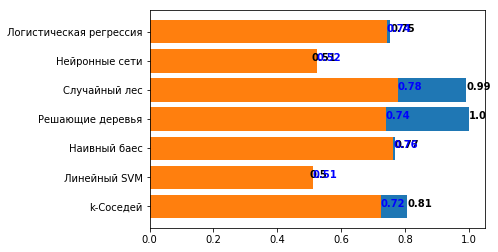

In [18]:
%matplotlib inline
from matplotlib import pylab as plt
plt.barh(names,scores_train)
for i, v in enumerate(scores_train):
    plt.text(v , i , str(round(v,2)), color='black', fontweight='bold')
plt.barh(names,scores)
for i, v in enumerate(scores):
    plt.text(v , i , str(round(v,2)), color='blue', fontweight='bold')

<font color=darkblue>Время выполнения каждого алгоритма. Сравните их между собой(если увеличить размер обучающей выборки то пропорция значительно поменяется)

<BarContainer object of 7 artists>

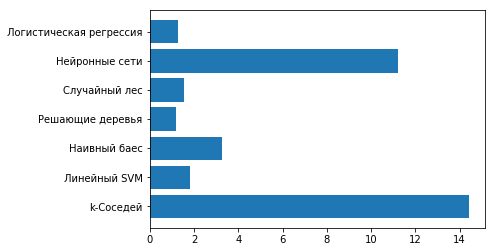

In [19]:
plt.barh(names,times)

# 3. Получили baseline который попробуем улучшить 
<font color=darkblue>Обратите внимание что все алгоритмы дают примерно одинаковый результат на тесте, SVM (очень мощного алгоритма)
проблема линейного алгоритма в том что вещественный признаки отличаются по масштабу от большинства справочных данных, закодированных Dummy.  

## 3.1. Заполнение пустых значений в данных 

<font color=darkblue>проверим кол-во пустых значений, если данных достуточно то часто используют удаление строк где есть хоть одно пустое 
значение атрибута 

In [20]:
for feature in df.columns:
    number = len(df) - len(df[df.isnull().apply(lambda x: not(x[feature]), axis=1)])
    print("{0:20} - {1} пустых значений.".format(feature, number))

Год выпуска          - 1365 пустых значений.
КПП                  - 1365 пустых значений.
Привод               - 1365 пустых значений.
Пробег               - 1365 пустых значений.
Тип кузова           - 1365 пустых значений.
Состояние            - 1365 пустых значений.
Срок владения        - 3490 пустых значений.
Цвет                 - 1365 пустых значений.
Руль                 - 1521 пустых значений.
Владельцы            - 1425 пустых значений.
ПТС                  - 1365 пустых значений.
Комментарий          - 239 пустых значений.
Марка                - 0 пустых значений.
Модель               - 0 пустых значений.
Город                - 103 пустых значений.
Объем двигателя      - 1366 пустых значений.
Мощность двигателя   - 1366 пустых значений.
Двигатель            - 1366 пустых значений.
Цена                 - 0 пустых значений.
Символов в объявлении - 239 пустых значений.


 ### 3.1.1. Категориальные признаки
<font color=darkblue> Заполнение пустых значений у категориальных признаков на отдельное значение справочника
 
 Также возможно применение стратегии замены на самое частоиспользуемое значение.
  

In [21]:
df["КПП"] = df["КПП"].fillna("empty")
df["Привод"] = df["Привод"].fillna("empty")
df["Тип кузова"] = df["Тип кузова"].fillna("empty")
df["Состояние"] = df["Состояние"].fillna("empty")
df["Цвет"] = df["Цвет"].fillna("empty")
df["Руль"] = df["Руль"].fillna("empty")
df["Владельцы"] = df["Владельцы"].fillna("empty")
df["ПТС"] = df["ПТС"].fillna("empty")
df["Город"] = df["Город"].fillna("empty")
df["Двигатель"] = df["Двигатель"].fillna("empty")
df["Срок владения"] = df["Срок владения"].fillna("empty")

### 3.1.2. Вещественные признаки
<font color=darkblue>существует множество вариантов, самые популярные:
- замена средним значением по всей выборке 
- матричные преобразования
- замена значением по методу k-ближайших значений 
- замена нулем 
- em-алшоритм
- интерполяция 

#### 3.1.2.1 Применим dummy кодирование
<font color=darkblue>для этого нужно перевести вещественные признаки к строковому значению. и тогда NaN будет отдельным признаком 

In [22]:
df_allstr=df.astype(str)
df_allstr = pd.get_dummies(df_allstr)
df_allstr.shape

(5059, 11699)

<font color=darkblue>Почти в 2 раза увеличилось число признаков, но посчитаем на тестовой выборке для всех моделей 

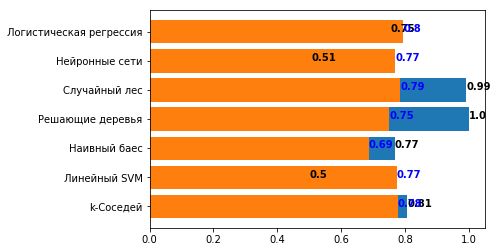

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_allstr, y, test_size=0.2,random_state=0)

scores=[]
times=[]
for name, clf in zip(names, classifiers):
    start_time=time.time() 
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    scores.append( accuracy_score(y_predicted, y_test)  ) 
    
    times.append(time.time() -start_time )

plt.barh(names,scores_train)
for i, v in enumerate(scores_train):
    plt.text(v , i , str(round(v,2)), color='black', fontweight='bold')
    
plt.barh(names,scores)
for i, v in enumerate(scores):
    plt.text(v , i , str(round(v,2)), color='blue', fontweight='bold')


<BarContainer object of 7 artists>

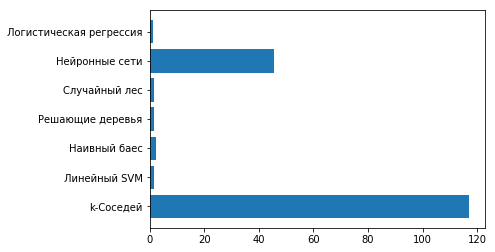

In [24]:
plt.barh(names,times)

<font color=darkblue>Линейные методы значительно улучшили свои показатели особенно(SVN), но время выполнения стало очень длительным из-за числа признаков, необходимо сократить их, выполняя отбор признаков

In [25]:
print('Количество признаков', df_allstr.columns.shape[0])

Количество признаков 11699


#### 1.2.2 Применим интерполяцию преобразование числовых признаков 
<font color=darkblue>- замену пустых на интерполированное значение

<font color=darkblue>- преобразование к отрезку (0,1)

<font color=darkblue>Воспользуемся методом interpolate который входит в состав библиотеки pandas для замены пустых значений

In [26]:
interp = df[["Цена", "Пробег", "Год выпуска", "Объем двигателя", "Мощность двигателя","Символов в объявлении"]]

interp = interp.sort_values(by="Цена")
interp.tail()

,Цена,Пробег,Год выпуска,Объем двигателя,Мощность двигателя,Символов в объявлении
1193,8776882,nan,nan,nan,nan,6627.00
3185,9770000,nan,nan,nan,nan,2801.00
2214,10024680,nan,nan,nan,nan,1563.00
1444,10052855,2206.00,2018.00,3.00,367.00,3552.00
464,13700000,7016.00,2016.00,5.20,610.00,1138.00


In [27]:
interp = interp.interpolate(method="linear")
interp.tail()

,Цена,Пробег,Год выпуска,Объем двигателя,Мощность двигателя,Символов в объявлении
1193,8776882,8850.77,2017.54,3.39,387.31,6627.00
3185,9770000,6635.85,2017.69,3.26,380.54,2801.00
2214,10024680,4420.92,2017.85,3.13,373.77,1563.00
1444,10052855,2206.00,2018.00,3.00,367.00,3552.00
464,13700000,7016.00,2016.00,5.20,610.00,1138.00


<font color=darkblue>для приведения к отрезку (0,1) воспользуемся метод MinMaxScaler

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(interp)
interp = pd.DataFrame(scaler.transform(interp), columns=["Цена", "Пробег", "Год выпуска", "Объем двигателя", "Мощность двигателя","Символов в объявлении"])

<font color=darkblue>Заменим исходные колонки на преобразованные 

In [29]:
df_interp = df.copy()
df_interp[["Цена", "Пробег", "Год выпуска", "Объем двигателя", "Мощность двигателя","Символов в объявлении"]] =\
    interp[["Цена", "Пробег", "Год выпуска", "Объем двигателя", "Мощность двигателя","Символов в объявлении"]]
df_interp.head()

,Год выпуска,КПП,Привод,Пробег,Тип кузова,Состояние,Срок владения,Цвет,Руль,Владельцы,ПТС,Комментарий,Марка,Модель,Город,Объем двигателя,Мощность двигателя,Двигатель,Цена,Символов в объявлении
0,0.58,empty,empty,0.13,empty,empty,empty,empty,empty,empty,empty,выгода до 200000 руб. по программе трейд-ин+кр...,Toyota,RAV 4 IV (CA40) Рестайлинг,Санкт-Петербург,0.07,0.02,empty,0.00,0.03
1,0.52,empty,empty,0.23,empty,empty,empty,empty,empty,empty,empty,"Комплектация КЛАССИК.- Ручки дверей, зеркала з...",УАЗ,Pickup I Рестайлинг 2,Красноярск,0.10,0.04,empty,0.00,0.00
2,0.29,empty,empty,0.15,empty,empty,empty,empty,empty,empty,empty,Автосалон Модус официальный дилер Nissan в гор...,Nissan,Qashqai II,Сочи,0.08,0.04,empty,0.00,0.01
3,0.57,механическая,передний,0.10,хэтчбек 5 дв.,Не требует ремонта,empty,серебристый,Левый,3 или более,Оригинал,В отличном состоянии. Автомобиль обслуживался ...,Ford,Focus II Рестайлинг,Москва,0.10,0.04,Бензин,0.00,0.00
4,0.75,empty,empty,0.00,empty,empty,empty,empty,empty,empty,empty,"Экстерьер: Топливный бак 66 л,Интерьер: Индика...",Mercedes-Benz,GLC Coupe C253 250 d,Краснодар,0.15,0.09,empty,0.00,0.00


In [30]:
df_interp = pd.get_dummies(df_interp)
print('Количество признаков', df_interp.columns.shape[0])

Количество признаков 6056


<font color=darkblue>Количество признаков как в исходном случае. расчитаем точность для всех алгоритмов 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_interp, y, test_size=0.2,random_state=0)

scores=[]
times=[]
for name, clf in zip(names, classifiers):
    start_time=time.time() 
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    scores.append( accuracy_score(y_predicted, y_test)  ) 
    times.append(time.time() -start_time )


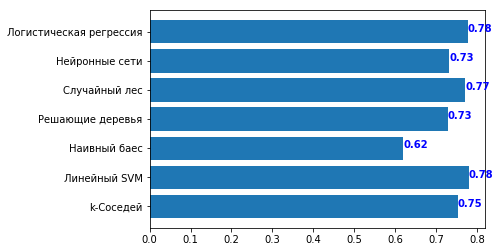

In [32]:
plt.barh(names,scores)
for i, v in enumerate(scores):
    plt.text(v , i , str(round(v,2)), color='blue', fontweight='bold')

<font color=darkblue>Дополнительно можно проводить биндинг и дискретизацию вещественных значений, когда мы признаком делаем не каждое число,
а диапазон. Но в данном примере это не приволит к улучшению. 

## 3.2. Отбор признаков на основании модели 
<font color=darkblue>отбор признаков может проводиться на основании:
- одномерных статистик 
- отбор признаков на основании модели 
- итерационный отбор признаков(итерационный отбор применяется для небольшого числа признаков, метод очень трудоемок) 

Применим отбор "признаков на основании модели(feature_selection.SelectFromModel)" с применением классификатора RandomForestClassifier. 
на вход подставляем данные df_allstr (пример где мы закодировали вещественные признаки отдельными справочниками) и ограничим количество признаков до значения 200 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_allstr, y, test_size=0.2,random_state=0)

from sklearn.feature_selection import SelectFromModel

select = SelectFromModel(RandomForestClassifier(),max_features=200)

%time select.fit(X_train,y_train)

CPU times: user 1.47 s, sys: 101 ms, total: 1.57 s
Wall time: 1.57 s


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        max_features=200, norm_order=1, prefit=False, threshold=None)

In [34]:
print('отобрано признаков: ',np.count_nonzero(select.get_support()==True))

отобрано признаков:  200


In [35]:
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

## 4. Проверим качество на отобранных признаках выберем модель для оптимизации

In [36]:
X_train_select=select.transform(X_train)
X_test_select=select.transform(X_test)

In [37]:
scores=[]
times=[]
for name, clf in zip(names, classifiers):
    start_time=time.time() 
    clf.fit(X_train_select, y_train)
    y_predicted = clf.predict(X_test_select)
    scores.append( accuracy_score(y_predicted, y_test)  ) 
    times.append(time.time() -start_time )

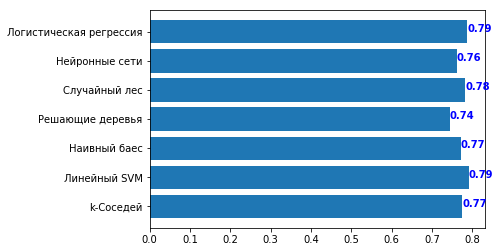

In [38]:
plt.barh(names,scores)
for i, v in enumerate(scores):
    plt.text(v , i , str(round(v,2)), color='blue', fontweight='bold')

In [39]:
X_train_select.shape

(4047, 200)

## 5 Проведем поиск по гиперпараметрам (gridsearch)
<font color=darkblue>возьмем для оптимизацию логистическую регресию с, зададим массив параметров  

In [40]:
from sklearn.model_selection import GridSearchCV
svc = LogisticRegression()
parameters = [{"penalty": ["l1","l2"],
              "C": [10**i for i in range(-3, 4)],
              "solver": [  "liblinear",  "saga"]}]

svc_clf = GridSearchCV(svc, parameters, cv=3)
svc_clf.fit(X_train_select, y_train)
svc_clf.best_score_

0.8089943167778602

<font color=darkblue>Лучшие параметры модели:

In [41]:
svc_clf.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

<font color=darkblue>Результат необходимо проверить на тестовой(контрольной) выборке. 

In [42]:
clf=LogisticRegression(**svc_clf.best_params_)
clf.fit(X_train_select, y_train)
y_predicted = clf.predict(X_test_select)
accuracy_score(y_predicted, y_test)


0.7875494071146245

## 6. Применим популярные промышленные решения 
<font color=darkblue>xgboost и catboost от Яндекс, который позволяют в том числе использовать GPU 

загрузим библиотеки 

In [43]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

#### XGBoost
<font color=darkblue>на вход подадим отобранные признаки 

In [44]:
clf = XGBClassifier()
clf.fit(X_train_select, y_train)

y_predicted = clf.predict(X_test_select)
print(classification_report(y_predicted, y_test))
print('Accuracy',accuracy_score(y_predicted, y_test)) 

              precision    recall  f1-score   support

          no       0.64      0.93      0.76       354
         yes       0.95      0.72      0.82       658

   micro avg       0.79      0.79      0.79      1012
   macro avg       0.80      0.83      0.79      1012
weighted avg       0.84      0.79      0.80      1012

Accuracy 0.7934782608695652


#### CatBoost
<font color=darkblue>Обратите внимание что catboost может работать с начальным датасетом, не проводя кодирование и преобразований, достаточно только:
- закодировать Y числами 
- удалить поле "Комментарий"

In [45]:
df_train = df.iloc[y_train.index].drop(columns=["Комментарий"])
df_test = df.iloc[y_test.index].drop(columns=["Комментарий"])
y_train_01 = np.where(y_train == 'yes',1,0)
y_test_01 = np.where(y_test == 'yes',1,0)

<font color=darkblue>- указать cat_features - номера колонок содержащие категориальные значения
- определить параметр nan_mode стратегию обработки пустых строк, 

Возможнные значения параметра nan_mode:
- "Forbidden" — NaN values are not supported, their presence raises an exception.
- "Min" — Each NaN float feature is processed as the minimum value from the dataset.
- "Max" — Each NaN float feature is processed as the maximum value from the dataset.

In [46]:
cat_features = [df_train.columns.get_loc(x) for x in ["КПП", "Привод", "Тип кузова", "Состояние", "Срок владения", "Цвет", 
                                                      "Руль", "Владельцы", "ПТС","Марка", "Модель", "Город", "Двигатель"]]

clf = CatBoostClassifier(nan_mode="Min")
clf.fit(df_train, y_train_01  , cat_features=cat_features, logging_level="Silent")

y_predicted = clf.predict(df_test)
print(classification_report(y_predicted, y_test_01))
print('Accuracy', accuracy_score(y_predicted, y_test_01))

              precision    recall  f1-score   support

         0.0       0.70      0.88      0.78       408
         1.0       0.90      0.74      0.81       604

   micro avg       0.80      0.80      0.80      1012
   macro avg       0.80      0.81      0.79      1012
weighted avg       0.82      0.80      0.80      1012

Accuracy 0.7954545454545454


In [47]:
df_train.shape

(4047, 19)

<font color=darkblue>Мы применили catboost на исходных данных без преобразований и получили сопоставимый результат, используя только 19 начальных признаков 

## 7 Анализ точности и полноты 
<font color=darkblue>Дополнительные возможности мы получаем при анализе точности и полноты. изобразим какую точность мы может достигнуть при заданных уровнях полноты, для этого построим гривую точности и полноты для классификаторов :
<font color=darkblue>- "Наивный баес"
<font color=darkblue>- "Решающие деревья"
<font color=darkblue>- "Случайный лес"
<font color=darkblue>- "Логистическая регрессия"

    

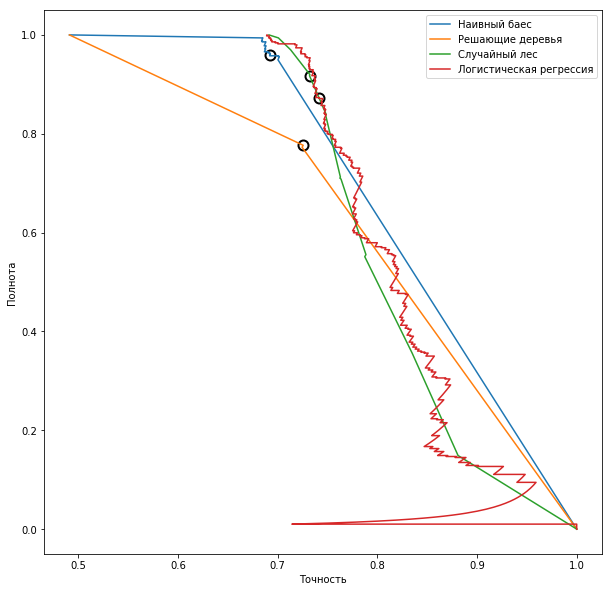

In [48]:
from sklearn.metrics import precision_recall_curve
class_dict = dict(zip(names, classifiers))
predict_proba_clfs = [ "Наивный баес", "Решающие деревья", 
                     "Случайный лес", "Логистическая регрессия"]

plt.figure(figsize=(10, 10))
plt.xlabel("Точность")
plt.ylabel("Полнота")

for i in range(7):
    name = names[i]
    clf = class_dict[name]

    if name in predict_proba_clfs:
        precision, recall, thresholds = precision_recall_curve(y_test_01, clf.predict_proba(X_test_select)[:, 1])

        close_zero = np.argmin(np.abs(thresholds - 0.5))
        plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, c='k', fillstyle="none", mew=2)
        plt.plot(precision, recall, label=name)

plt.legend(loc="best")
plt.show()

<font color=darkblue> На графике черный кружок означает значение точности и полноты при пороге по умолчанию = 0.5, далее мы увидим как можно использовать порог для подбора точности или полноты. 
Предположим мы хотим поощрять за популярное объявление и нам очень важно быть уверенными что объявление действительно популярно. Проверим "точность" для класса "популярно"

In [49]:
from sklearn.metrics import precision_recall_curve
clf=LogisticRegression().fit(X_train_select,y_train_01)
y_scores = clf.predict_proba(X_test_select)

precisions,recalls,thresholds = precision_recall_curve(y_test_01,y_scores[:, 1])

print("Точность", accuracy_score(clf.predict(X_test_select), y_test_01))
print(classification_report(clf.predict(X_test_select), y_test_01))

Точность 0.7875494071146245
              precision    recall  f1-score   support

           0       0.71      0.85      0.77       428
           1       0.87      0.74      0.80       584

   micro avg       0.79      0.79      0.79      1012
   macro avg       0.79      0.80      0.79      1012
weighted avg       0.80      0.79      0.79      1012



In [50]:
y_scores.shape

(1012, 2)

<font color=darkblue> мы видим что предсказываем попурятный класс с вероятностью 89 процентов, нам этого недостаточно, попробуем увеличить точность, для этого построим график зависимости точности и полноты от порога. 

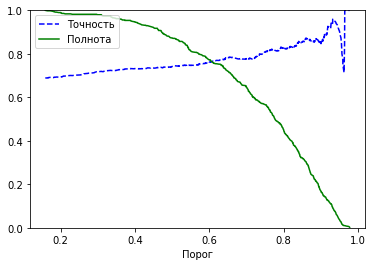

In [51]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],'b--',label='Точность')
    plt.plot(thresholds,recalls[:-1],'g-',label='Полнота')
    plt.xlabel('Порог')
    plt.legend(loc='upper left')
    plt.ylim([0,1])


plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

<font color=darkblue> Изменяем параметр "порог", установим в 0.25. Обратите внимание что общая точность даже немного повысилась и мы теперь предсказываем что класс популярен с точностью 99% что является очень высоким показателем уверенности.

In [52]:
print("Точность", accuracy_score(  (clf.predict_proba(X_test_select)[:,1] >= 0.25).astype(bool) , y_test_01))
print(classification_report((clf.predict_proba(X_test_select)[:,1] >= 0.25).astype(bool) , y_test_01))


Точность 0.7875494071146245
              precision    recall  f1-score   support

       False       0.60      0.97      0.74       318
        True       0.98      0.70      0.82       694

   micro avg       0.79      0.79      0.79      1012
   macro avg       0.79      0.84      0.78      1012
weighted avg       0.86      0.79      0.80      1012



## 8 Кодирование значений (mean encoding)

Здесь мы рассмотрим такую мощную технику как **mean encoding** (также известную как **likelihood encoding** , **impact coding**, **target coding**).

Основная идея данной техники:
> _Добавление новых переменных, основанных на некоторых признаках и цели (target)_.

Простейший случай:
> Кодирование каждой категориальной переменной с соответствующим ей средним значением _целевой переменной_ (_target_).


Рассмотрим следующий пример:

<img src="../images/part02/mean_encoding-01.png">


Для предоставленных данных задачей будет _бинарная классификация_.

В данном случае _категориальной переменной_ (или _признаком_) будет **feature**, в которой хранятся имена городов.

Именно эту переменную мы и будем кодировать.


Мы будем кодировать каждый город с соответствующим _средним значением цели_.

Рассмотрим пример для города **Москва** (_Moscow_):

В предоставленной таблице имеется 5 строк с этим городом:
* 3 строки с целью (target) = **0**;
* 2 строки с целью (target) = **1**;

Формула вычисления кодированного значения:

$$
encode = \frac{positive}{nrows},
$$

где:
* $positive$ - это количество _позитивных_ значений _цели_ для данного города (в данном случае $positive = 2$),
* $nrows$ - это количество строк с данным городом (в данном случае $nrows = 5$).

В нашем случае, результатом будет следующее значение:

$$
\frac{2}{5} = 0.4
$$

Аналогичным образом кодируем оставшиеся имена городов.


Примечание:
> _Вы можете применить данный подход не только для задачи **бинарной классификации**, но и для множества других задач, ведь основная идея не изменится._


Далее Вы узнаете как:
* _конструировать **mean encodings**_
* _правильно их проверить_
* _их расширить_


Способы кодирования значений:


* $Likelihood = \frac{Goods}{Goods + Bads} = mean\left(target\right)$


* $Weight\hspace{5pt}of\hspace{5pt}Evidence = \ln{\left(\frac{Goods}{Bads}\right)} * 100$


* $Count = Goods = sum\left(target\right)$


* $Diff = Goods - Bads$


Приступим к конструированию признаков.

Предположим, что мы уже разделили данные на _обучающие (тренировочные)_ и _проверочные (тестовые)_ (**X_tr, X_val** соответственно).

Следующая часть кода показывает, как конструировать _mean encoding_ для произвольной колонки, и поместить полученные значения в _DataFrame_ (**train_new, val_new** соответственно):

```python
means = X_tr.groupby(col)['target'].mean()
train_new[col + 'mean_target'] = train_new[col].map(means)
val_new[col + 'mean_target'] = val_new[col].map(means)

means
```


После выполнения данной части кода над каждой колонки мы можем начать обучение XGBoost-модели используя новые данные.

Ниже расположен код обучения модели на новых данных:

```python
dtrain = xgb.DMatrix(train_new, label=y_tr)
dvalid = xgb.DMatrix(val_new, label=y_val)

evallist = [(dtrain, 'train'), (dvalid, 'eval')]
evals_result3 = {}
model = xgb.train(xgb_par, dtrain, 3000, evals=evallist, verbose_eval=30, evals_result=evals_result3, early_stopping_rounds=50)
```

Вот результат обучения модели (используя код выше):
<img src="../images/part02/mean_encoding-02.png">

На этом графике что-то не так.
После нескольких эпох показатель _ROC AUC_ для тренировочных данных очень близок к **1**, когда у проверочных данных, данный показатель, около **0.55**.

Это явный знак ужасного _переобучения_.

Это произошло из-за того, что мы сначала разделили данные на _тренировочный_ и _проверочный_ наборы данных, а потом уже применили **mean encoding**.
Если бы в первую очередь применили **mean encoding**, а только потом разделили бы на _тренировочный_ и _проверочный_ наборы данных, то мы бы не получили такое ужасное _переобучение_.


### Итог:


Мы рассмотрели концепцию **mean encoding** и применили её на простом примере, который, очевидно, не может использовать полученные значения.

Сначала нам нужно разобраться с _переобучением_, нам нужна какая-то _регуляризация_.

Далее мы рассмотрим несколько методов _регуляризации_.


### Напоминание про правильную проверку

Прежде чем мы приступим рассмотрению методов _регуляризации_, давайте вспомним как правильно выполнять проверку результатов:
* Локальные эксперименты (_Local experiments_):
    * Разделить данные на _тренировочный_ (**X_tr**) и _проверочный_ (**X_val**) наборы (_Split the data in **X tr** and **X val** parts_)
    * Выполнить оценку кодирования на **X_tr** (_Estimate encodings on **X tr**_)
    * Выполнить сопоставление с **X_tr** и **X_val** (_Map them to **X tr** and **X val**_)
    * Применить _регуляризацию_ на **X_tr** (_Regularize them on **X tr**_)
    * Проверить модель на **X_tr** и **X_val** (_Validate model on **X tr**/**X val** split_)

Даже не думайте об _оценке кодировок_ (**estimating encodings**) до разделения данных!

* Представление (_Submission_):
    * Выполнить оценку кодирования по всему _тренировочному_ набору (_Estimate encodings on whole **train** data_)
    * Выполнить сопоставление с _тренировочным_ и _тестовым_ наборами (_Map them to **train** and **test**_)
    * Применить _регуляризацию_ на **тренировочном** наборе (_Regularize on **train**_)
    * Обучить на _тренировочном_ наборе (_Fit on **train**_)



<img src="../images/part02/mean_encoding-05.png">


### Regularization (Регуляризация)

Только что, мы, с Вами, поняли, что **mean encoding** не может использоваться "как есть".

Для применения данной техники, необходима какая-либо _регуляризация_.

В данном разделе мы разберём несколько вариантов _регуляризации **mean encoding**_, а именно:
* **Cross-validation loop** (**CV loop**);
* **Smoothing**;
* **Adding random noise**;
* **Sorting and calculating expanding mean**.


#### Настройка общих параметров

Для начала настроим несколько параметров, для проверки применения _регуляризации_.


Имя целевой колонки (_target_)

In [53]:
target_col_name = 'Популярно'
suffix = '_mean_target'


В качестве набора данных будем использовать данные полученные в разделе "**3.1.1. Категориальные признаки**"

In [54]:
y_tmp = y.map({'no': 0, 'yes': 1,})

df_tmp = df.copy(True)
df_tmp = df_tmp.drop(columns=['Комментарий'])
df_tmp[target_col_name] = y_tmp


In [55]:
print(df_tmp.shape)

df_tmp = df_tmp.dropna(axis='index', how='any')
y_tmp = df_tmp[target_col_name]

print(df_tmp.shape)

(5059, 20)
(3548, 20)


Загрузим класс _K-кратной стратифицированной перекрестной проверки_ (**Stratified K-Fold cross-validation**).


In [56]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder


In [57]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
le = LabelEncoder()


Выберем колонки, к которым будем применять **mean encoding** и _регуляризацию_.

И создаём экземпляр класса **StratifiedKFold**.


In [58]:
cols = [ col_name for col_name in df_tmp.columns if (df_tmp[col_name].dtype == object) ]
cols


['КПП',
 'Привод',
 'Тип кузова',
 'Состояние',
 'Срок владения',
 'Цвет',
 'Руль',
 'Владельцы',
 'ПТС',
 'Марка',
 'Модель',
 'Город',
 'Двигатель']

Создадим функцию, котороая будет получать на вход _набор данных_ (уже с **mean encoding**) и _ответы_ (_target_).

Получив _набор данных_, функция выполнаяет _dummy-преобразование_, после чего разделяет результат преобразования на _тренировочный_ и _тестовый_ наборы данных.

В конце, данная функция, возвращает преобразованный _набор данных_, _тренировочный_ и _тестовый_ _наборы данных_.


In [59]:
def prepare_and_split_df(df, y, enc_cols):
    df_new = df.copy(True)
    
    for col in enc_cols:
        le.fit(df_new[col].unique())
        # df_new[col+'_label'] = le.transform(df_new[col])
        df_new[col] = le.transform(df_new[col])
    
    X_train, X_test, y_train, y_test = train_test_split(df_new, y, test_size=0.2, random_state=0)
    return df_new, X_train, X_test, y_train, y_test
    
    # if needs to select most important faetures
    # select = SelectFromModel(RandomForestClassifier(), max_features=200)
    # select.fit(X_train, y_train)
    
    # X_train_select = select.transform(X_train)
    # X_test_select = select.transform(X_test)
    
    # return df_new, X_train_select, X_test_select, y_train, y_test


Создадим функцию, которая на вход получает _тренировочные_ и, если необходимо выполнить проверку на _точность_ обучения, _проверочные_ данные.

Получив необходимые данные, функция начинает _обучение_ модели _Логистической Регрессии_ с применением _перекрёстной проверки_ (_cross-validation_) различных параметров модели, для выбора наилучших параметров.

После нахождения лучших параметров, функция повторно _обучает_ модель, но теперь уже с применением найденных лучших параметров.

Затем, если переданы _проверочные_ данные, выполняет _оценку_ результата обучения модели.

В конце, функция возвращает обученную модель.


In [60]:
def train_model_on_reg_data(X_train, y_train, X_test=None, y_test=None):
    # apply Grid Search for finding the best parameters.
    svc = LogisticRegression()
    parameters = [{"penalty": ["l1","l2"],
                  "C": [10**i for i in range(-3, 4)],
                  "solver": ["liblinear",  "saga"]}]

    svc_clf = GridSearchCV(svc, parameters, cv=3)
    svc_clf.fit(X_train, y_train)
    
    # print information about best score and best parameters
    print('best score: {0}'.format(svc_clf.best_score_))
    print('best param: {0}'.format(svc_clf.best_params_))
    
    # training our model with best parameters
    clf = LogisticRegression(**svc_clf.best_params_)
    clf.fit(X_train, y_train)
    
    if (X_test is not None) and (y_test is not None):
        y_predicted = clf.predict(X_test)
        print('accuracy: {0}'.format(accuracy_score(y_predicted, y_test)))
        print(classification_report(y_predicted, y_test))
    
    return clf


Создадим ещё одну функцию, которая на вход получает _функцию регуляризации_, _исходный набор данных_ (в котором находятся и _ответы_ (_target_)), _имена колонок, для которых нужно применить **mean encoding**_, и _вспомогательные параметры, которые могут понадобиться методу **регуляризации**_.

Получив необходимые данные, функция выделяет _ответы_ (_target_) в отдельную переменную и удаляет эту колонку (с _ответами_) из набора данных.

Затем, функция вызывает, ранее созданную, функцию **prepare_and_split_df**, для разделения на _тренировочный_ и _тестовый_ наборы данных.

После этого, функция вызывает, ранее созданную, функцию **train_model_on_reg_data**, для обучения модели.

В конце, функция возвращает обученную модель.


In [61]:
def get_model_with_regularization(func, df, enc_cols, *args, **kwargs):
    df_new = df.copy(True)
    y_new = df_new[target_col_name]
    # df_new = df_new.drop(columns=[target_col_name])
    
    df_reg, X_train, X_test, y_train, y_test = prepare_and_split_df(df_new, y_new, enc_cols)
    X_train = func(X_train, enc_cols, *args, **kwargs)
    
    for col in enc_cols:
        means = X_train.groupby(col)[col + suffix].mean()
        # X_train[col + suffix] = X_train[col].map(means)
        X_test[col + suffix] = X_test[col].map(means)
        
        # fill NaN a global mean value
        X_test[col + suffix].fillna(X_train[col].mean(), inplace=True)
    
    # some information about new data
    # print('new shape: ', df_reg.shape)
    # print('some columns:')
    # print(sorted(list(df_reg.columns))[:15])
    
    # drop target column
    X_train = X_train.drop(columns=[target_col_name])
    X_test = X_test.drop(columns=[target_col_name])
    
    # training model with new data.
    res_model = train_model_on_reg_data(X_train, y_train, X_test, y_test)
    return res_model

Давайте начнём подробное рассмотрение методов _регуляризации **mean encoding**_.

Мы начнём с **CV loop** _регуляризации_.


#### Cross-validation loop (CV loop)


Это очень интуитивный и надёжный метод.

Для данной точки данных мы не хотим использовать целевую переменную (_target_) этой точки данных.

Таким образом, мы разделяем данные на _K непересекающиеся подмножества_ - **folds** (см. рисунок ниже).

<img src="../images/part02/mean_encoding-03.png">


Чтобы получить **mean encoding** для некоторого подмножества, мы не используем точки данных из этого подмножества и оцениваем кодирование только на остальной части подмножества.

Мы итеративно проходим через все подмножества данных.

Обычно, 4-5 _подмножеств_ (_folds_) достаточно, чтобы получить неплохие результаты, и Вам не нужно настраивать это число.


А сейчас мы узнаем как применяется данный метод на практике.

Предположим, что наши _тренировочные_ данные расположены в переменной **df_tr**, которая имеет тип **pandas.DataFrame**, и рассмотрим код ниже:

```python
y_tr = df_tr['target'].values  # target variable
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

skf_values = skf.split(np.zeros(y_tr.shape[0]), y_tr)
for tr_ind, cal_ind in skf_values:
    X_tr, X_val = df_tr.iloc[tr_ind], df_tr.iloc[val_ind]
    
    for col in cols:  # iterate though the columns we want to encode
        means = X_val[col].map(X_tr.groupby(col)['target'].mean())
        X_val[col+'_mean_target'] = means
    train_new.iloc[val_ind] = X_val

prior = df_tr['target'].mean()  # global mean
train_new.fillna(prior, inplace=True)  # fill NaNs with global mean
```


Добавим средние значения признаков (_mean encoded features_) в новую тренировочную переменную **train_new**, которая имеет тип **pandas.DataFrame**.
Во внешнем цикле мы перебираем стратифицированные K-fold итератор, чтобы разделить _тренировочные_ данные на части (_chunks_).

**X_tr** используется для оценки кодировки.
**X_val** используется для применения оценивающей кодировки.

После этого мы перебираем все столбцы и сопоставляем оценочные кодировки с **X_val**.
В конце внешнего цикла мы заполняем **train_new** полученным результатом.
Однако, некоторые редкие категории могут присутствовать только в одном _подмножестве_ (_fold_).
Поэтому, у нас нет данных для оценки _целевого среднего_ (_target mean_) для них.
Вот почему у нас есть **NaN**-значения.
Мы можем заполнить их _глобальным средним_ (_global mean_).

Как видите, процесс довольно простой.


А сейчас зададимся вопросом:
> _Теряем ли мы информацию о **целевой переменной** (**target**) или нет?_

Рассмотрим следующий пример:
<img src="../images/part02/mean_encoding-04.png">


Здесь мы хотим кодировать **Москву** по схеме [**leave-one-out CV** (**LOO**)](http://www.machinelearning.ru/wiki/index.php?title=CV#.D0.9A.D0.BE.D0.BD.D1.82.D1.80.D0.BE.D0.BB.D1.8C_.D0.BF.D0.BE_.D0.BE.D1.82.D0.B4.D0.B5.D0.BB.D1.8C.D0.BD.D1.8B.D0.BC_.D0.BE.D0.B1.D1.8A.D0.B5.D0.BA.D1.82.D0.B0.D0.BC_.28leave-one-out_CV.29).

Для первой строки мы получаем **0.5**, потому что в остальных строках есть две **1** и два **0**:

$$
\frac{1 + 1 + 0 + 0}{4} = \frac{2}{4} = 0.5
$$

Аналогичным образом получаем **0.25** для 2-ой строки, и т.д.

Однако, если присмотреться, то видно, что данные идеально разделены, строки со _средним значением функции_ (*featur_mean*) $\geq$ **0.5** имеют _цель_ (_target_) __0__, а остальные строки имеют _цель_ (_target_) **1**.

Мы явно не использовали _целевую переменную_ (_target_), однако наша кодировка предвзята.
Кроме того, этот эффект остаётся действительным даже для **KFold-схемы**, только мягче.

В связи с этим, можно было подумать, что этот тип _регуляризации_ бесполезен, но это не так.

На практике, если у Вас достаточно данных и Вы используете 4 или 5 _подмножеств_ (_folds_), кодирование будет отлично работать с данной стратегией _регуляризации_.
Просто будьте осторожны и используйте правильную проверку.


Ниже представлена функция, которая реализует данный метод _регуляризации_.

In [62]:
def reg_cv_loop(df, enc_cols):
    df_new = df.copy(True)
    
    nrows = df_new.shape[0]
    prior = df_new[target_col_name].mean()  # global mean
    
    for col in enc_cols:
        df_new[col + suffix] = np.nan

    skf_values = skf.split(np.zeros(nrows), df_new[target_col_name])
    for tr_ind, val_ind in skf_values:
        X_tr, X_val = df_new.iloc[tr_ind], df_new.iloc[val_ind]
        
        for col in enc_cols:
            means = X_val[col].map(X_tr.groupby(col)[target_col_name].mean())
            X_val[col + suffix] = means
        
        df_new.iloc[val_ind] = X_val
    
    df_new.fillna(prior, inplace=True)  # fill NANs with global mean
    return df_new


Запускаем обучение с данным видом _регуляризации_.

In [63]:
res_model = get_model_with_regularization(func=reg_cv_loop, df=df_tmp, enc_cols=cols)


best score: 0.7251585623678647
best param: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy: 0.6985915492957746
              precision    recall  f1-score   support

           0       0.17      0.54      0.26        68
           1       0.94      0.71      0.81       642

   micro avg       0.70      0.70      0.70       710
   macro avg       0.55      0.63      0.53       710
weighted avg       0.86      0.70      0.76       710



#### Smoothing (Сглаживание)

Данный стратегия _регуляризации_ основана на следующей идее:
> Если категория имеет много точек данных, то мы можем доверять этой оценочной кодировке (_estimating encoding_), но если категория имее мало точек данных - всё наоборот.

Следующая формула использует данную идею:

$$
\frac{mean\left(target\right) * nrows + globalmean * alpha}{nrows + alpha}
$$

Данная формула имеет гипер-параметр **alpha**, который контролирует степень _регуляризации_.
Когда **alpha** равна __0__, у нас нет _регуляризации_, а когда **alpha** стремится к $\infty$ (бесконечности), всё превращается в _глобальное среднее_ (_globalmean_).
В некотором смысле **alpha** равна размеру категории, которой мы можем доверять.


Также можно использовать другую формулу.

В основном всё, что "наказывает" категории для кодирования, можно считать _сглаживанием_ (_smoothing_).

_Сглаживание_, очевидно, не будет работать само по себе, но мы можем объединить его, например, с _**CV loop**-регуляризацией_.


Ниже представлена функция, которая реализует данный метод _регуляризации_.


In [64]:
# with possible using "skf" (StratifiedKFold).
def reg_smoothing(df, enc_cols, alpha:float=0.5, use_skf:bool=True):
    df_new = df.copy(True)
    
    nrows = df_new.shape[0]
    prior = df_new[target_col_name].mean()  # global mean
    
    def apply_to_chunk(X_tr, X_val):
        result = X_val.copy(True)
        
        for col in enc_cols:
            means_and_counts = X_tr[[col, target_col_name]].groupby(col)[target_col_name].agg(['mean', 'count'])

            means = []
            for mean, count in means_and_counts[['mean', 'count']].values:
                # rows count that contain current value
                # tmp_val = ((mean * count) + (prior * alpha)) / (count + alpha)
                
                # all rows count
                tmp_val = ((mean * nrows) + (prior * alpha)) / (nrows + alpha)
                
                means.append(tmp_val)

            means_lst = []
            means_lst.append(means_and_counts.index.values)
            means_lst.append(means)

            # means = X_tr.groupby(col)[target_col_name].mean()
            means = pd.Series(means_lst[1], index=means_lst[0], name=target_col_name)
            
            means = X_val[col].map(means)
            result[col + suffix] = means
        
        return result
    
    for col in enc_cols:
        df_new[col + suffix] = np.nan
    
    if use_skf:
        skf_values = skf.split(np.zeros(nrows), df_new[target_col_name])
        for tr_ind, val_ind in skf_values:
            X_tr, X_val = df_new.iloc[tr_ind], df_new.iloc[val_ind]
            df_new.iloc[val_ind] = apply_to_chunk(X_tr, X_val)
        
    else:
        df_new = apply_to_chunk(df_new, df_new)

    df_new.fillna(prior, inplace=True)  # fill NANs with global mean
    return df_new


Настраиваем значение **alpha**

In [65]:
alpha = 0.5

Используя **StratifiedKFold**

In [66]:
res_model = get_model_with_regularization(func=reg_smoothing, df=df_tmp, enc_cols=cols, alpha=alpha, use_skf=True)

best score: 0.7241014799154334
best param: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy: 0.6985915492957746
              precision    recall  f1-score   support

           0       0.17      0.54      0.26        70
           1       0.93      0.72      0.81       640

   micro avg       0.70      0.70      0.70       710
   macro avg       0.55      0.63      0.54       710
weighted avg       0.86      0.70      0.76       710



Не используя **StratifiedKFold**

In [67]:
res_model = get_model_with_regularization(func=reg_smoothing, df=df_tmp, enc_cols=cols, alpha=alpha, use_skf=False)

best score: 0.8463706835799859
best param: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy: 0.6647887323943662
              precision    recall  f1-score   support

           0       0.28      0.44      0.34       142
           1       0.84      0.72      0.78       568

   micro avg       0.66      0.66      0.66       710
   macro avg       0.56      0.58      0.56       710
weighted avg       0.73      0.66      0.69       710



#### Noise (Шум)

Ещё один способ _регуляризации_ **mean encodings** - добавить некоторый _шум_ (_noise_).
Без _регуляризации_ **mean encodings** имеют лучшее качество для _тренировочных_ данных, чем для _тестовых_ данных.

Добавляя _шум_, мы просто ухудшаем качество кодирования на _обучающих_ данных.

Этот метод довольно нестабилен, его трудно заставить работать.
Основная проблема заключается в количестве _шума_, который нужно добавить.

Слишком много _шума_ превратит функцию в мусор, в то время как слишком мало шума означает плохую _регуляризацию_.

Этот метод обычно используется вместе с [**leave-one-out CV** (**LOO**)](http://www.machinelearning.ru/wiki/index.php?title=CV#.D0.9A.D0.BE.D0.BD.D1.82.D1.80.D0.BE.D0.BB.D1.8C_.D0.BF.D0.BE_.D0.BE.D1.82.D0.B4.D0.B5.D0.BB.D1.8C.D0.BD.D1.8B.D0.BC_.D0.BE.D0.B1.D1.8A.D0.B5.D0.BA.D1.82.D0.B0.D0.BC_.28leave-one-out_CV.29) _регуляризацией_.

Нужно аккуратно его настраивать.
Таким образом, это, вероятно, не лучший вариант, если у Вас немного времени.


Ниже представлена функция, которая реализует данный метод _регуляризации_ совместно с **CV loop** _регуляризацией_.


In [68]:
import random

In [69]:
# with possible using "skf" (StratifiedKFold).
def reg_noise(df, enc_cols, alpha:float=0.0008, use_skf:bool=True):
    df_new = df.copy(True)
    
    nrows = df_new.shape[0]
    prior = df_new[target_col_name].mean()  # global mean
    
    def apply_to_chunk(X_tr, X_val):
        # result = X_val.copy(True)
        
        # apply CV loop regularization
        result = reg_cv_loop(X_val, enc_cols)
        
        seq = [i for i in range(nrows)]
        for col in enc_cols:
            new_col_name = col + suffix
            
            # noise_arr = np.random.normal(0, 1, 100)
            # noise_arr = alpha * np.array(random.choice(seq))
            noise_arr = alpha * np.array(random.sample(seq, result.shape[0]))
            result[new_col_name] = result[new_col_name].values + noise_arr
        
        return result
    
    for col in enc_cols:
        df_new[col + suffix] = np.nan
    
    if use_skf:
        skf_values = skf.split(np.zeros(nrows), df_new[target_col_name])
        for tr_ind, val_ind in skf_values:
            X_tr, X_val = df_new.iloc[tr_ind], df_new.iloc[val_ind]
            df_new.iloc[val_ind] = apply_to_chunk(X_tr, X_val)
        
    else:
        df_new = apply_to_chunk(df_new, df_new)

    df_new.fillna(prior, inplace=True)  # fill NANs with global mean
    return df_new


Настройка параметра **alpha**

In [70]:
alpha = 0.0008

Используя **StratifiedKFold**

In [71]:
res_model = get_model_with_regularization(func=reg_noise, df=df_tmp, enc_cols=cols, alpha=alpha, use_skf=True)

best score: 0.7142353770260746
best param: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy: 0.6901408450704225
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.69      0.82       710

   micro avg       0.69      0.69      0.69       710
   macro avg       0.50      0.35      0.41       710
weighted avg       1.00      0.69      0.82       710



Не используя **StratifiedKFold**

In [72]:
res_model = get_model_with_regularization(func=reg_noise, df=df_tmp, enc_cols=cols, alpha=alpha, use_skf=False)

best score: 0.7177589852008457
best param: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy: 0.6943661971830986
              precision    recall  f1-score   support

           0       0.05      0.57      0.10        21
           1       0.98      0.70      0.82       689

   micro avg       0.69      0.69      0.69       710
   macro avg       0.52      0.63      0.46       710
weighted avg       0.95      0.69      0.79       710



#### Expanding mean (Расширение среднего)

Последний метод _регуляризации_, который мы рассмотрим, основан на _расширении среднего_ (_expanding mean_).
Идея очень простая.

Мы фиксируем некоторый порядок сортировки наших данных и используем только строки от __0__ до $n - 1$ для вычисления _кодировки_ для строки $n$.
Вы можете проверить простую _pandas-реализацию_ реализованную во фрагменте кода ниже:

```python
cumsum = df_tr.groupby(col)['target'].cumsum() - df_tr['target']
cumcnt = df_tr.groupby(col).cumcount()
train_new[col+'_mean_target'] = cumsum / cumcnt
```

**Cumsum** хранит [кумулятивную сумму (_cumulative sum_)](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D0%BC%D0%B5%D0%B6%D1%83%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D1%81%D1%83%D0%BC%D0%BC%D0%B0) _целевой переменной_ (_target_) до данной строки, а **cumcnt** хранит кумулятивный счётчик (_cumulative count_).

Этот метод вводит наименьшее количество утечки из _целевой переменной_ (_target_) и не требует настройки гипер-параметров.
Единственным недостатком является то, что качество признака неоднородно.
Но ничего страшного.

Мы можем усреднять модели по кодировкам, рассчитанным из разных перестановок данных.
Также стоит отметить, что метод _расширения среднего_ (_expanding mean_) используется в **CatBoost gradient boosting trees library**, которая великолепно работает с наборами данных с категориальными признаками.


Ниже представлена функция, которая реализует данный метод _регуляризации_.


In [73]:
def reg_expanding_mean(df, enc_cols, use_skf:bool=True):
    df_new = df.copy(True)
    
    nrows = df_new.shape[0]
    prior = df_new[target_col_name].mean()  # global mean
    
    def apply_to_chunk(X_tr, X_val):
        result = X_val.copy(True)
        
        for col in enc_cols:
            cumsum = X_tr.groupby(col)[target_col_name].cumsum() - X_tr[target_col_name]
            cumcnt = X_tr.groupby(col).cumcount()

            result[col + suffix] = cumsum / cumcnt
                    
        return result
    
    for col in enc_cols:
        df_new[col + suffix] = np.nan
    
    if use_skf:
        skf_values = skf.split(np.zeros(nrows), df_new[target_col_name])
        for tr_ind, val_ind in skf_values:
            X_tr, X_val = df_new.iloc[tr_ind], df_new.iloc[val_ind]
            df_new.iloc[val_ind] = apply_to_chunk(X_tr, X_val)
        
    else:
        df_new = apply_to_chunk(df_new, df_new)

    df_new.fillna(prior, inplace=True)  # fill NANs with global mean
    return df_new


Используя **StratifiedKFold**

In [74]:
res_model = get_model_with_regularization(func=reg_noise, df=df_tmp, enc_cols=cols, alpha=alpha, use_skf=True)

best score: 0.7142353770260746
best param: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy: 0.6971830985915493
              precision    recall  f1-score   support

           0       0.04      0.73      0.07        11
           1       0.99      0.70      0.82       699

   micro avg       0.70      0.70      0.70       710
   macro avg       0.52      0.71      0.44       710
weighted avg       0.98      0.70      0.81       710



Не используя **StratifiedKFold**

In [75]:
res_model = get_model_with_regularization(func=reg_noise, df=df_tmp, enc_cols=cols, alpha=alpha, use_skf=False)

best score: 0.7156448202959831
best param: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy: 0.6901408450704225
              precision    recall  f1-score   support

           0       0.04      0.50      0.08        18
           1       0.98      0.70      0.81       692

   micro avg       0.69      0.69      0.69       710
   macro avg       0.51      0.60      0.44       710
weighted avg       0.96      0.69      0.80       710



#### Итог

Мы рассмотрели 4 различных типа _регуляризации_.

Каждый метод имеет свои преимущества и недостатки.

Для практических задач рекомендуется применять _**CV loop**-регуляризацию_ или метод **расширения среднего** (**expanding mean**).

Они самые надежные и легконастраиваемые.


#### Основные преимущества и недостатки mean encodings

* Преимущества:
    * Компактное преобразование категориальных переменных (_Compact transformation of categorical variables_)
    * Мощное основание для проектирования признаков (_Powerful basis for feature engineering_)


* Недостатки:
    * Необходима тщательная проверка, потому как существует множество способов для _переобучения_ (_Need careful validation, there a lot of ways to overfit_)
    * Значительные улучшения только для некоторых наборов данных (_Significant improvements only on specific datasets_)
